In [ ]:
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

In [ ]:
import pandas as pd
import spacy, json
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np


import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models

import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.optimizers import Adam
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['this is such an amazing movie!', 'music this very movie']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (2, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(2, 512)
Pooled Outputs Values:[ 0.76262903  0.99280983 -0.1861188   0.3667384   0.15233697  0.6550443
  0.9681154  -0.948627    0.00216151 -0.9877732   0.06842711 -0.9763061 ]
Sequence Outputs Shape:(2, 128, 512)
Sequence Outputs Values:[[-0.28946322  0.34321278  0.332315   ...  0.21300861  0.7102075
  -0.05771185]
 [-0.28742063  0.31980968 -0.23018526 ...  0.58455    -0.21329752
   0.7269202 ]
 [-0.6615702   0.6887679  -0.8743295  ...  0.10877275 -0.2617321
   0.47855455]
 ...
 [-0.22561184 -0.28925595 -0.0706443  ...  0.47566038  0.8327713
   0.40025303]
 [-0.29824215 -0.27473155 -0.05450528 ...  0.488497    1.0955361
   0.18163332]
 [-0.44378126  0.009308    0.07223716 ...  0.17290114  1.1833243
   0.07897985]]


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor(
[[0.7414849 ]
 [0.72591954]], shape=(2, 1), dtype=float32)


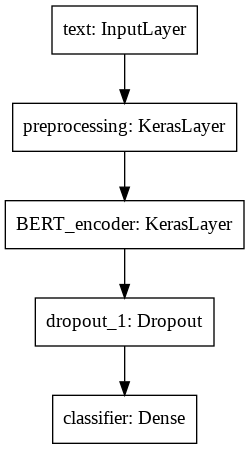

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
df3 = pd.read_json(open("data3.json", "r", encoding="utf8"))
texts_len = df3['text'].apply(len)
df3.drop(df3[texts_len<50].index, inplace=True)
df3['text'] = df3['title'] + df3['text']
df3 = df3[['text', 'themes']]
df3.head()

,text,themes
0,Body and Soul II(for Coleman Hawkins)\nThe str...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,NovelI.\n\nNo one's serious at seventeen.\n—On...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,FlyingOne said to me tonight or was it day \no...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Photograph of People Dancing in FranceIt's tru...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,War PhotographA naked child is running\nalong ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
with open('themes3.json', 'r') as f:
    theme_codes3 = json.load(f)

In [ ]:
theme = 'arts & sciences'

In [ ]:
theme_codes3[theme]

69

In [ ]:
theme_index = theme_codes3[theme]
df3['themes'] = pd.Series([row['themes'][theme_index] for index, row in df3.iterrows()])

In [ ]:
df3.shape

(16545, 2)

In [ ]:
df3.isna().sum()

text        0
themes    529
dtype: int64

In [ ]:
df3 = df3.dropna()

In [ ]:
df3.head()

,text,themes
0,Body and Soul II(for Coleman Hawkins)\nThe str...,0.0
1,NovelI.\n\nNo one's serious at seventeen.\n—On...,0.0
2,FlyingOne said to me tonight or was it day \no...,0.0
3,Photograph of People Dancing in FranceIt's tru...,1.0
4,War PhotographA naked child is running\nalong ...,1.0


In [ ]:
optimizer = Adam( learning_rate=5e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
df3.isna().sum()

text      0
themes    0
dtype: int64

In [ ]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(df3['text'], df3['themes'], test_size=0.1, random_state=42)

In [ ]:
classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'pooled_output': (N 28763649    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=X_train, y=Y_train, 
                               validation_data=(np.array(X_test),np.array(Y_test)),
                               epochs=3)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/3
451/451 [==============================] - 111s 231ms/step - loss: 0.4419 - binary_accuracy: 0.8454 - val_loss: 0.4349 - val_binary_accuracy: 0.8427
Epoch 2/3
451/451 [==============================] - 104s 230ms/step - loss: 0.4311 - binary_accuracy: 0.8475 - val_loss: 0.4378 - val_binary_accuracy: 0.8427
Epoch 3/3
451/451 [==============================] - 105s 232ms/step - loss: 0.4251 - binary_accuracy: 0.8475 - val_loss: 0.4359 - val_binary_accuracy: 0.8427


In [ ]:
themes_to_predict = ['arts & sciences', 'living', 'social commentaries', 
                     'relationships', 'love', 'nature', 'war', 'lgbtq', 'audio & music', 'public domain', 
                     'body', 'death', 'summer', 'religion', 'violence']

In [ ]:
optimizer = Adam( learning_rate=5e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
df3 = pd.read_json(open("data3.json", "r", encoding="utf8"))
texts_len = df3['text'].apply(len)
df3.drop(df3[texts_len<50].index, inplace=True)
df3['text'] = df3['title'] + df3['text']
df3 = df3[['text', 'themes']]
print(f'Training model with {tfhub_handle_encoder}')
for theme in themes_to_predict:
  print("theme - ", theme)
  theme_index = theme_codes3[theme]
  df3_c = df3.copy()
  df3_c['themes'] = pd.Series([row['themes'][theme_index] for index, row in df3_c.iterrows()])
  df3_c = df3_c.dropna()
  X_train, X_test, Y_train, Y_test = model_selection.train_test_split(df3_c['text'], df3_c['themes'], test_size=0.1, random_state=42)
  history = classifier_model.fit(x=X_train, y=Y_train, 
                               validation_data=(np.array(X_test),np.array(Y_test)),
                               epochs=3)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
theme -  arts & sciences
Epoch 1/3
451/451 [==============================] - 104s 230ms/step - loss: 0.4269 - binary_accuracy: 0.8475 - val_loss: 0.5247 - val_binary_accuracy: 0.7937
Epoch 2/3
451/451 [==============================] - 104s 230ms/step - loss: 0.4246 - binary_accuracy: 0.8475 - val_loss: 0.5252 - val_binary_accuracy: 0.7937
Epoch 3/3
451/451 [==============================] - 104s 230ms/step - loss: 0.4221 - binary_accuracy: 0.8475 - val_loss: 0.5313 - val_binary_accuracy: 0.7937
theme -  living
Epoch 1/3
451/451 [==============================] - 103s 229ms/step - loss: 0.6552 - binary_accuracy: 0.6559 - val_loss: 0.6207 - val_binary_accuracy: 0.6779
Epoch 2/3
451/451 [==============================] - 104s 230ms/step - loss: 0.6442 - binary_accuracy: 0.6559 - val_loss: 0.6213 - val_binary_accuracy: 0.6779
Epoch 3/3
451/451 [==============================] - 103s 229ms/step - l